In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
# import importlib
# import seaborn as sns

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

### Load Data

In [34]:
file_list = user_path + '/PHYS469/saturation_spectroscopy/interim_data_list.txt'
oct10_raw_data = {}

with open(file_list, 'r') as file_names:
    # Go through good data files
    for file_path in file_names:
        file_path = file_path.strip()
        # Read the lines of the file
        with open(user_path+file_path, 'r') as f:
            lines = f.readlines()
        # Find end of the header (the line that starts with 'x ys')
        for i, line in enumerate(lines):
            if line.startswith('x	y'):
                lines_to_skip = i
                break

        # Read data (skip header)
        data = np.genfromtxt(user_path+file_path, skip_header=lines_to_skip, names=True, missing_values='nan', filling_values=0)
        reshaped_data = np.vstack([data[field] for field in data.dtype.names]).T

        # Add to a dict
        file_dict = {label: reshaped_data[:,i] for i,label in enumerate(data.dtype.names)}
        oct10_raw_data[file_path[53:57]] = file_dict

### Plot Raw Data

In [35]:
# def plot_raw_data(data_dict):
#     for run in data_dict.keys():
#         plt.plot(data_dict[run]['x'], data_dict[run]['y3'], label=run)


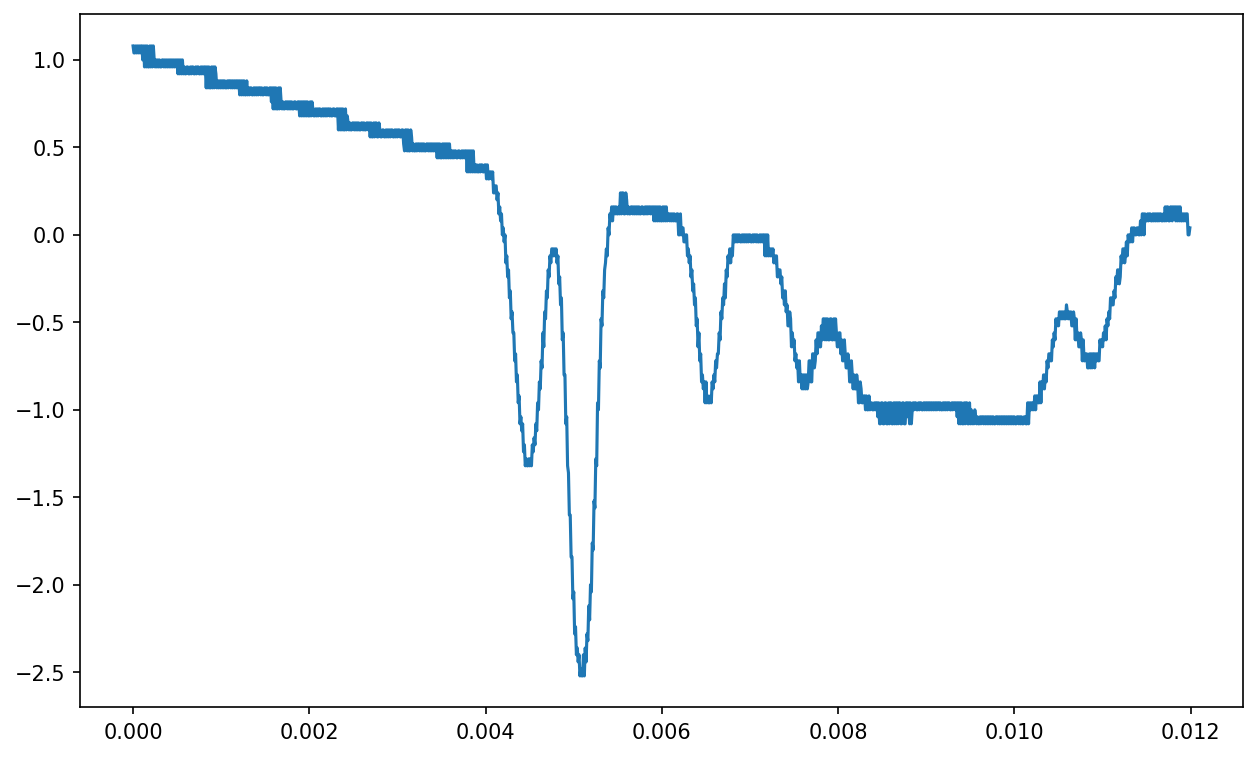

In [55]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(oct10_raw_data['run3']['x'], (-1)*oct10_raw_data['run3']['y3']);